This notebook provides the plotting functions for Figure 2 a-f. These figures show the reconstruction of a chirp response from a two-photon recording, using the classical pipeline, the GP pipeline, and an extended GP pipeline with warping applied.

In [1]:
%matplotlib inline

from datetime import datetime 
import GPy
import h5py
import json
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import choice
import os
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.4/dist-packages/matplotlib/cbook.py:128: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the matplotlib toolkit finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
 /usr/local/lib/python3.4/dist-packages/IPython/html.py:14: ShimWarning:The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.


In [2]:
from util.load_hdf5 import *
from util.zscore import *
from util.compute_bounds import *
from util.plot_roi import *
from util.fill_bounds import *

In [3]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = "arial"

%config InlineBackend.figure_format = 'png'

sns.set_style('white')

title_fontsize = 13
label_fontsize = 12

fig_p = {
    'dpi': 600, 
    'bbox_inches': 'tight'
}

In [4]:
directories = json.load(open('directories.json'))

data = load_hdf5(directories['data'] + 'SMP_M1_RR2_BC2_ChirpI2.h5')
data_linear = load_hdf5(directories['data'] + 'SMP_M1_RR2_BC2_ChirpI2.h5')
data_stack = load_hdf5(directories['data'] + 'SMP_M1_RR2_BC2_Z.h5')
data_df = pd.read_csv(directories['data'] + 'SMP_M1_RR2_BC2_ChirpI2.csv', index_col = 0)
data_df = data_df.groupby(['roi', 'frame']).mean().reset_index()

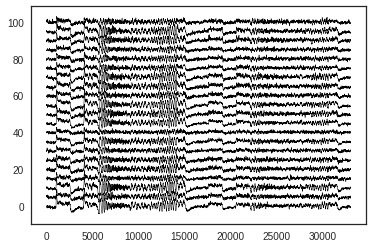

In [7]:
plt.plot(data_linear['Snippets0'].mean(axis = 1) + np.linspace(0, 20, 21) * 5, color = 'k', linewidth = 0.5)

In [63]:
np.unique(data_df['roi'])[8]

9.0

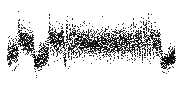

In [76]:
sns.set_style('white')

roi = np.unique(data_df['roi'])[8]

traces = data_df.loc[data_df['roi'] == roi, 'y']
tpnts  = data_df.loc[data_df['roi'] == roi, 'x_t']
tpnts_warp = data_df.loc[data_df['roi'] == roi, 'x_t_warped']

stimulus_duration = 66

stimulus_mask = tpnts < (stimulus_duration / 2)
traces  = traces[stimulus_mask]
tpnts  = tpnts[stimulus_mask]
tpnts_warp = tpnts_warp[stimulus_mask]

fig, ax = plt.subplots(1)

ax.scatter(tpnts, traces, color = 'k', s = 0.5)

ax.set_xlim(0, stimulus_duration / 2);
ax.set_ylim(-3, 3)
plt.tick_params(axis='both', which='major', labelsize='small')
ax.set_xlabel('', fontsize=10)
ax.set_xticklabels([]);
ax.set_yticklabels([]);
sns.despine(left = True, bottom = True, ax = ax)

fig.set_size_inches(3, 1.5)

# plt.tight_layout()

# plt.savefig(directories['figs'] + 'reconstruct/' + 'raw_data_points.svg', **fig_p)

In [40]:
y = traces[:, None]
x = tpnts[:, None] #- stimulus_duration / 2

In [41]:
num_inducing = np.arange(25, 300, 25)
time_elapsed = np.zeros(num_inducing.shape)

In [42]:
for itx, itn in enumerate(num_inducing):
    m1 = GPy.models.SparseGPRegression(
        x,
        y,
        num_inducing = itn,
        kernel = GPy.kern.RBF(1)
    )
    
    start = datetime.now() 

    m1.optimize_restarts(3, messages = True, max_iters = 20)
    
    time_elapsed[itx] = (datetime.now() - start).total_seconds() /3

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    00s17  04   3.860677e+03   6.046679e+05 
    00s90  22   3.692355e+03   2.249750e+02 
Runtime:     00s90
Optimization status: Maximum number of f evaluations reached

Optimization restart 1/3, f = 3692.3550004172325
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    00s18  04   4.633348e+03   1.569459e+04 
    00s95  22   4.541288e+03   1.704855e+02 
Runtime:     00s95
Optimization status: Maximum number of f evaluations reached

Optimization restart 2/3, f = 4541.287794324791
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    00s17  04   4.912461e+03   9.958807e+04 
    00s96  22   4.671187e+03   7.650335e-01 
Runtime:     00s96
Optimization status: Maximum number of f evaluations reached

Optimization restart 3/3, f = 4671.187205326967
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f        

KeyboardInterrupt: 

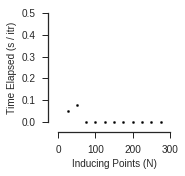

In [43]:
sns.set_style('ticks')

fig, ax = plt.subplots()

ax.scatter(num_inducing, time_elapsed / 20, s = 5, color = 'k', clip_on = False)

ax.set_xlim(0, 300)
ax.set_ylim(0, .5)
plt.tick_params(axis='both', which='major', labelsize='medium')
ax.set_xlabel('Inducing Points (N)', fontsize = 10)
ax.set_ylabel('Time Elapsed (s / itr)', fontsize = 10)

sns.despine(ax = ax, offset = 10)

fig.set_size_inches(2, 2)

plt.savefig(directories['figs'] + 'reconstruct/' + 'time_vs_points.svg', **fig_p)

In [13]:
random_seq = choice(x.shape[0], size = x.shape[0], replace = False)

n_train = int(np.floor(0.8 * x.shape[0]))
i_train = np.array(random_seq)[:n_train]
i_test = np.array(random_seq)[n_train:]

In [14]:
lik = []

for itx, itn in enumerate(num_inducing):
    m1 = GPy.models.SparseGPRegression(
        x[i_train, :],
        y[i_train, :],
        num_inducing = itn,
        kernel = GPy.kern.RBF(1)
    )

    m1.optimize_restarts(3, messages = True, max_iters = 20)

    lik.append(np.sum(m1.log_predictive_density(x[i_test, :], y[i_test, :])))
    
lik = np.array(lik)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    00s16  04   3.271988e+03   1.473020e+05 
    00s79  22   2.954984e+03   9.825176e+00 
Runtime:     00s79
Optimization status: Maximum number of f evaluations reached

Optimization restart 1/3, f = 2954.9840364092925
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    00s11  03   4.424758e+03   2.146479e+05 
    00s19  05   3.769204e+03   1.914052e+04 
    00s91  22   3.654518e+03   4.026537e+00 
Runtime:     00s91
Optimization status: Maximum number of f evaluations reached

Optimization restart 2/3, f = 3654.518039993295
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    00s14  03   4.050618e+03   9.790093e+05 
    00s18  04   3.915093e+03   3.732919e+04 
    01s08  22   3.751696e+03   3.877411e-01 
Runtime:     01s08
Optimization status: Maximum number of f evaluations reached

Optimization restart 3/3, f = 

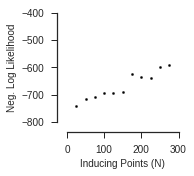

In [15]:
fig, ax = plt.subplots()

ax.scatter(num_inducing, lik, s = 5, color = 'k', clip_on = False)

ax.set_xlim(0, 300)
ax.set_ylim(-800, -400)
plt.tick_params(axis='both', which='major', labelsize='medium')
ax.set_xlabel('Inducing Points (N)', fontsize = 10)
ax.set_ylabel('Neg. Log Likelihood', fontsize = 10)

sns.despine(ax = ax, offset = 10)

fig.set_size_inches(2, 2)

plt.savefig(directories['figs'] + 'reconstruct/' + 'likelihood_vs_points.svg', **fig_p)

In [16]:
num_iters = np.arange(10, 110, 10)

lik_iters = []

for itx, it_iters in enumerate(num_iters):
    m1 = GPy.models.SparseGPRegression(
        x[i_train, :],
        y[i_train, :],
        num_inducing = 300,
        kernel = GPy.kern.RBF(1)
    )

    m1.optimize_restarts(1, messages = True, max_iters = it_iters)

    lik_iters.append(np.sum(m1.log_predictive_density(x[i_test, :], y[i_test, :])))
    
lik_iters = np.array(lik_iters)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    01s09  05   2.883447e+03   2.360247e+03 
    03s44  15   2.709436e+03   2.097573e+05 
Runtime:     03s44
Optimization status: Maximum number of f evaluations reached

Optimization restart 1/1, f = 2709.4359007394687
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    01s06  05   2.883447e+03   2.360244e+03 
    05s35  22   2.554909e+03   1.013578e+04 
Runtime:     05s35
Optimization status: Maximum number of f evaluations reached

Optimization restart 1/1, f = 2554.9086496531145
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    00s00  00   3.636336e+03           nan 
    04s54  19   2.685955e+03   3.763918e+05 
    08s01  32   2.506335e+03   8.329902e+02 
Runtime:     08s01
Optimization status: Maximum number of f evaluations reached

Optimization restart 1/1, f = 2506.335120579716
Running L-BFGS-B (Scipy imp

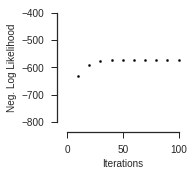

In [17]:
fig, ax = plt.subplots()

ax.scatter(num_iters, lik_iters, s = 5, color = 'k', clip_on = False)

ax.set_xlim(0, 100)
ax.set_ylim(-800, -400)
plt.tick_params(axis='both', which='major', labelsize='medium')
ax.set_xlabel('Iterations', fontsize=10)
ax.set_ylabel('Neg. Log Likelihood', fontsize=10)

sns.despine(ax = ax, offset = 10)

fig.set_size_inches(2, 2)

plt.savefig(directories['figs'] + 'reconstruct/' + 'likelihood_vs_iterations.svg', **fig_p)

In [45]:
y = traces[:, None]
x = tpnts[:, None] #- stimulus_duration / 2

m1 = GPy.models.SparseGPRegression(
    x,
    y,
    num_inducing = 300,
    kernel = GPy.kern.RBF(1)
)

m1.optimize_restarts(4, messages = True, max_iters = 20)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    03s39  12   3.361667e+03   3.785086e+05 
    06s72  22   3.153259e+03   8.743183e+03 
Runtime:     06s72
Optimization status: Maximum number of f evaluations reached

Optimization restart 1/4, f = 3153.2587664218654
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    03s76  12   4.671935e+03   1.240486e+01 
    06s95  22   4.671124e+03   6.691800e-02 
Runtime:     06s95
Optimization status: Maximum number of f evaluations reached

Optimization restart 2/4, f = 4671.124440017207
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    04s34  16   4.558870e+03   2.954768e+03 
    06s15  22   4.541527e+03   6.786222e+01 
Runtime:     06s15
Optimization status: Maximum number of f evaluations reached

Optimization restart 3/4, f = 4541.526576806045
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f        

In [54]:
x_new = np.linspace(0, stimulus_duration / 2, 33 * 24)[:, None]

mu, sig = m1.predict(x_new, include_likelihood = False)
_, sig_outer = m1.predict(x_new, include_likelihood = True)

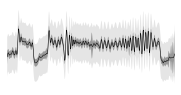

In [55]:
sns.set_style('white')

fig, ax = plt.subplots(1)

ax.plot(x_new, mu, color = 'k', linewidth = 0.5)

upper, lower = compute_bounds(mu, sig, n_sigma = 3)
  
ax.fill_between(
    x_new[:, 0], 
    upper[:, 0], 
    lower[:, 0], 
    facecolor = 'k',
    alpha = 0.33
)

upper, lower = compute_bounds(mu, sig_outer, n_sigma = 3)

ax.fill_between(
    x_new[:, 0], 
    upper[:, 0], 
    lower[:, 0], 
    facecolor = 'k',
    alpha = 0.10
)

ax.set_xlim(0, stimulus_duration / 2);
plt.tick_params(axis='both', which='major', labelsize='small')
ax.set_xlabel('', fontsize=10)
ax.set_xticklabels([]);
ax.set_yticklabels([]);
sns.despine(left = True, bottom = True, ax = ax)

fig.set_size_inches(3, 1.5)

plt.savefig(directories['figs'] + 'reconstruct/' + 'fitted_gaussian_process.svg', **fig_p)

In [48]:
y = traces[:, None]
X = tpnts_warp[:, None]

k1 = GPy.kern.RBF(1)

m2 = GPy.models.SparseGPRegression(
    X,
    y,
    num_inducing = 300,
    kernel = k1
)

m2.optimize_restarts(4, messages = True, max_iters = 20)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    01s21  04   3.699222e+03   8.385162e+03 
    05s80  18   3.248648e+03   3.411915e+04 
    07s08  22   3.159994e+03   1.075768e+04 
Runtime:     07s08
Optimization status: Maximum number of f evaluations reached

Optimization restart 1/4, f = 3159.994402014579
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    01s10  04   4.739321e+03   1.932943e+05 
    05s63  21   4.441120e+03   3.939269e+03 
    07s28  27   4.438385e+03   8.490598e+03 
Runtime:     07s28
Optimization status: Maximum number of f evaluations reached

Optimization restart 2/4, f = 4438.385297887655
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    02s32  08   4.450746e+03   1.339463e+03 
    04s56  16   4.432270e+03   3.067796e+03 
    06s12  22   4.421638e+03   3.195741e+02 
Runtime:     06s12
Optimization status: Maximum number of f evaluat

In [57]:
from sklearn.isotonic import IsotonicRegression

iso_reg = IsotonicRegression()
stimulus_mask = data_df['x_t'] < 32
iso_reg.fit(data_df['x_t_warped'][stimulus_mask], data_df['x_t'][stimulus_mask])

n_tpnts = 32 * 20
x_new = np.linspace(data_df['x_t'].min(), data_df['x_t'].max() / 2, n_tpnts)
x_new_unwarp = iso_reg.transform(x_new)

mu, sig = m2.predict(x_new[:, None], include_likelihood = False)
_, sig_outer = m2.predict(x_new[:, None], include_likelihood = True)

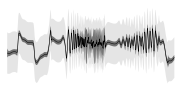

In [58]:
sns.set_style('white')

fig, ax = plt.subplots(1)

ax.plot(x_new_unwarp, mu, color = 'k', linewidth = 0.5)

upper, lower = compute_bounds(mu, sig, n_sigma = 3)
  
ax.fill_between(
    x_new_unwarp, 
    upper[:, 0], 
    lower[:, 0], 
    facecolor = 'k',
    alpha = 0.5
)

upper, lower = compute_bounds(mu, sig_outer, n_sigma = 3)

ax.fill_between(
    x_new_unwarp, 
    upper[:, 0], 
    lower[:, 0], 
    facecolor = 'k',
    alpha = 0.10
)

ax.set_xlim(0, 32);
ax.set_ylim(-3, 3);
plt.tick_params(axis='both', which='major', labelsize='small')
ax.set_xlabel('', fontsize=10)
ax.set_xticklabels([]);
ax.set_yticklabels([]);
sns.despine(left = True, bottom = True, ax = ax)
# ax.set_aspect(2)

fig.set_size_inches(3, 1.5)

plt.savefig(directories['figs'] + 'reconstruct/' + 'fitted_gaussian_process_warp.svg', **fig_p)

In [59]:
n_samples = 5
mu_post = m2.posterior_samples_f(x_new[:, None], size = n_samples)

 /usr/local/lib/python3.4/dist-packages/GPy/core/gp.py:500: RuntimeWarning:covariance is not positive-semidefinite.


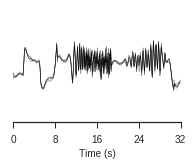

In [61]:
sns.set_style('ticks')

fig, ax = plt.subplots(1)

sample_colors = sns.color_palette('hls', n_samples)

offset = 0

for itx in range(n_samples):
    ax.plot(x_new_unwarp, mu_post[:, itx] + itx * offset, color = 'k', alpha = 0.5, linewidth = 0.5)
    
ax.set_xlim(0, 32);
ax.set_ylim(-3, 3);

plt.tick_params(axis='both', which='major', labelsize='medium')
ax.set_xlabel('Time (s)', fontsize=10)
ax.set_yticklabels([]);
plt.xticks([0, 8, 16, 24, 32])
sns.despine(left = True, ax = ax)
ax.get_yaxis().set_visible(False)
# ax.set_aspect(2)

fig.set_size_inches(3, 2)

plt.savefig(directories['figs'] + 'reconstruct/' + 'posterior_samples.svg', **fig_p)

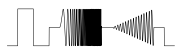

In [26]:
sns.set_style('white')

stimulus = load_hdf5('/rogerson_et_al/misc/chirp.h5')['chirp']
stimulus_range = stimulus.max() - stimulus.min()

stimulus_time = np.linspace(0, 32, stimulus.shape[0])

fig, ax = plt.subplots(1)

ax.plot(stimulus_time, zscore(stimulus, single = False), color = 'k', linewidth = 0.5)

sns.despine(left = True, bottom = True, ax = ax)
plt.tick_params(axis='both', which='major', labelsize='small')

ax.set_xticklabels([]);
ax.set_yticklabels([]);
ax.set_xlim(0, 32)
# ax.set_aspect(1)

fig.set_size_inches(3, 0.75)

plt.savefig(directories['figs'] + 'reconstruct/' + 'chirp_stimulus.svg', **fig_p)

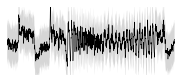

In [62]:
sns.set_style('white')

i_roi = 7

trace_mean = zscore(data_linear['Snippets0'][:16000, :, i_roi], single = False).mean(axis = 1)
trace_std = zscore(data_linear['Snippets0'][:16000, :, i_roi], single = False).std()
trace_time = data_linear['SnippetsTimes0'][:16000, 0, i_roi]
trace_time -= trace_time.min()

fig, ax = plt.subplots(1)

ax.plot(trace_time, trace_mean, color = 'k', linewidth = 0.5)

ax.fill_between(
    trace_time,
    trace_mean + 2 * trace_std, 
    trace_mean - 2 * trace_std, 
    facecolor = 'k',
    alpha = 0.16
)

sns.despine(left = True, ax = ax)
ax.set_xlim(0, 32)
ax.set_ylim(-3.5, 3.5)
plt.tick_params(axis='both', which='major', labelsize='medium')
ax.set_xlabel('', fontsize=10)
ax.set_xticklabels([]);
ax.set_yticklabels([]);
sns.despine(left = True, bottom = True, ax = ax)

fig.set_size_inches(3, 1.25)

plt.savefig(directories['figs'] + 'reconstruct/' + 'mean_trace.svg', **fig_p)